## Tectonics and Landscape Evolution Class part 1



#### We are going to use our field work measurements to create our model from the Teton Fault

In [46]:
#Importing required functions 

import pandas as pd
from landlab import RasterModelGrid, imshow_grid
from landlab.components import StreamPowerEroder, LinearDiffuser, FlowAccumulator,NormalFault
import numpy as np
import matplotlib.pyplot as plt
from FieldWork_class import FieldWork

In [47]:
#Import you field work data
data = pd.read_csv('/Users/poliveira/Projects_PhD/tect_land_project/field_work_teton_park.csv')
data

#Calculate parameters for your model
fw = FieldWork(data)
result = fw.calculate_dip_strike()

#Set the size of your area
x_size = 15000 # in meters
y_size  = 11250 # in meters
dx = 30
dy = 50
cols = 500
rows = 225

#rows,cols = fw.calculate_grid_size(x_size,y_size,dx,dy) 

#create basin_mg
basin_mg = RasterModelGrid((225,500),xy_spacing=(30,50))

# Add elevation field
z = basin_mg.add_zeros('topographic__elevation', at='node')
z += np.random.rand(z.size)

# Set boundary conditions to match Teton,
# we are seeting the outlet in the middle right of the model
# x_coordinate = (dx*cols)-dx
# y_coordinate = ((dy*rows)-dy)/2

# print(x_coordinate,y_coordinate)        

#node_id = basin_mg.find_nearest_node((x_coordinate,y_coordinate)) # (x-coordinate,y-coordinate)

#basin_mg.set_watershed_boundary_condition_outlet_id(55000, z)

basin_mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
# imshow_grid(basin_mg, 'topographic__elevation')
# plt.show()


The average strike is 10.0
The average dip is 58.904761904761905


In [48]:
## Initialise the landscape and parameters

# Dictionary for parameter values
params  = {'stream_power': {'K_sp': 5E-6, 
                        'n_sp': 1, 
                        'm_sp': 0.45}, 
                        'diffuser': {'D_diff': 0.001}}

K_sp = params['stream_power']['K_sp']
m_sp = params['stream_power']['m_sp']
n_sp = params['stream_power']['n_sp']

## Forward model evolution

n_steps = 100001
dt = 1000  # timestep in years

U = np.ones(basin_mg.number_of_nodes)
uplift_rate = 0.00005 #in meters/years

fa = FlowAccumulator(basin_mg, flow_director='D8')
ld = LinearDiffuser(basin_mg, linear_diffusivity=params['diffuser']['D_diff'])
sp = StreamPowerEroder(basin_mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp)

uplift_per_steps = dt * U

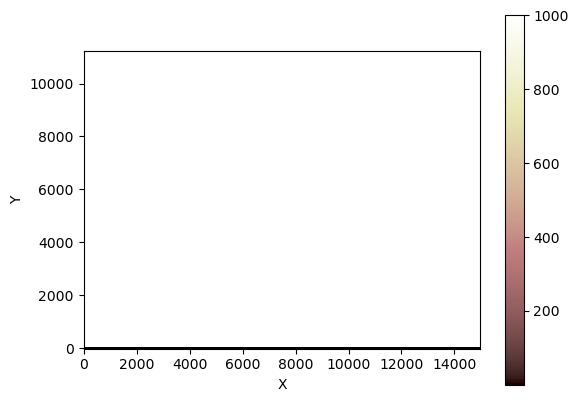

0


KeyboardInterrupt: 

In [49]:
for i in range(n_steps):

    basin_mg.at_node['topographic__elevation'][basin_mg.core_nodes] += uplift_per_steps[basin_mg.core_nodes]
    fa.run_one_step()
    sp.run_one_step(dt=dt)
    ld.run_one_step(dt)


    if i%100 == 0:
        imshow_grid(basin_mg, 'topographic__elevation')
        plt.show()
        print(i)